# Who Are Our Top Performing Zip Codes According To CRM Data?
---
### Summary
    1. Import Modules and Data
    2. Clean Data
        A. Convert/Index/Sort Data By 'datetime'
        B. Convert location zip to int
    3. Data Exploration
        A. How many jobs completed per zip?
        B. How much money was spent per zip?
    4. Merge Frequency df and Monetary df
    5. Rank each zip based on Frequency and Monetary value
    6. Label each zip based on rank
    7. Save Data
      
    
        


## 1. Import Modules and Data

In [165]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# disable chained assignments
pd.options.mode.chained_assignment = None

# See all data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-165-0c0ebdbb546a>:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [166]:
df = pd.read_csv("clean_crm_data.csv")

In [167]:
df.head(1)

,invoice_date,invoice_number,location_zip,total,completion_date
0,2021-01-15,18969046,80917.0,49.0,2021-01-15


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15673 entries, 0 to 15672
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   invoice_date     15673 non-null  object 
 1   invoice_number   15673 non-null  object 
 2   location_zip     15673 non-null  float64
 3   total            15673 non-null  float64
 4   completion_date  15673 non-null  object 
dtypes: float64(2), object(3)
memory usage: 612.4+ KB


## Clean Data

### A. Convert/Index/Sort Data By 'datetime'

In [169]:
# Convert invoice dates to pd date time
df['invoice_date'] = pd.to_datetime(df.invoice_date)

# Index DF with 'invoice_date' and sort ascending
df = df.sort_values(by='invoice_date', ascending=False)
df = df.set_index(df['invoice_date'])

In [170]:
df.dtypes

invoice_date       datetime64[ns]
invoice_number     object        
location_zip       float64       
total              float64       
completion_date    object        
dtype: object

In [171]:
df.invoice_date.min()

Timestamp('2018-06-01 00:00:00')

In [172]:
df.invoice_date.max()

Timestamp('2021-09-28 00:00:00')

### B. Convert location zip to int

In [173]:
df['location_zip'] = df.location_zip.astype(int)

In [174]:
df.dtypes

invoice_date       datetime64[ns]
invoice_number     object        
location_zip       int32         
total              float64       
completion_date    object        
dtype: object

## 3. Data Exploration

### A. How many jobs completed per zip?

In [175]:
# How many jobs were completed by zip?
frequency = df.groupby('location_zip').invoice_number.count().reset_index().sort_values('invoice_number', ascending=False)
frequency.head()

,location_zip,invoice_number
32,80919,1653
33,80920,1641
34,80921,1309
10,80132,1268
22,80906,1236


In [176]:
# Update column name
frequency = frequency.rename(columns={'invoice_number': 'frequency_count'})

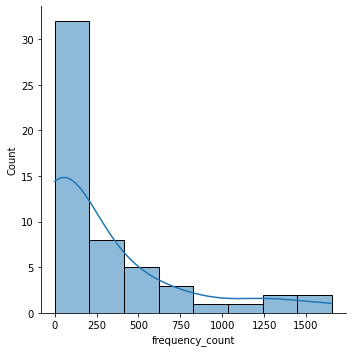

In [177]:
sns.displot(data=frequency, x='frequency_count', kde=True)

### B. How much money was spent per zip?

In [178]:
monetary = df.groupby('location_zip').total.sum().reset_index().sort_values('total', ascending=False)
monetary.head()

,location_zip,total
32,80919,489861.74
33,80920,466744.75
22,80906,449015.50
34,80921,347282.33
10,80132,311673.35


In [179]:
monetary = monetary.rename(columns={'total': 'monetary_sum'})

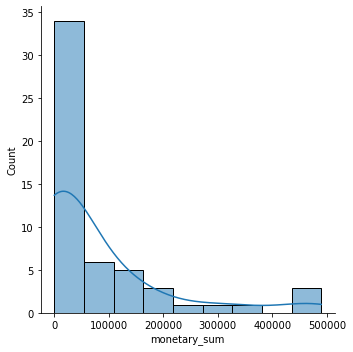

In [180]:
sns.displot(data=monetary, x='monetary_sum', kde=True)

## 4. Merge df's

In [181]:
df_f_m = frequency.merge(monetary, on='location_zip')

In [182]:
df_f_m.head()

,location_zip,frequency_count,monetary_sum
0,80919,1653,489861.74
1,80920,1641,466744.75
2,80921,1309,347282.33
3,80132,1268,311673.35
4,80906,1236,449015.50


## 5. Rank each zip based on Frequency and Monetary value

In [183]:
df_f_m['f_percentile'] = df_f_m['frequency_count'].rank(method='first', pct=True,ascending=True)
df_f_m['f_score'] = pd.qcut(df_f_m['f_percentile'], 4, labels=range(4,0,-1))
df_f_m['m_percentile'] = df_f_m['monetary_sum'].rank(method='first', pct=True,ascending=True)
df_f_m['m_score'] = pd.qcut(df_f_m['m_percentile'], 4, labels=range(4,0,-1))

In [184]:
df_f_m.head()

,location_zip,frequency_count,monetary_sum,f_percentile,f_score,m_percentile,m_score
0,80919,1653,489861.74,1.000000,1,1.000000,1
1,80920,1641,466744.75,0.981481,1,0.981481,1
2,80921,1309,347282.33,0.962963,1,0.944444,1
3,80132,1268,311673.35,0.944444,1,0.925926,1
4,80906,1236,449015.50,0.925926,1,0.962963,1


In [185]:
df_f_m.tail()

,location_zip,frequency_count,monetary_sum,f_percentile,f_score,m_percentile,m_score
49,22205,1,69.00,0.092593,4,0.055556,4
50,80809,1,121.95,0.111111,4,0.148148,4
51,80246,1,199.00,0.129630,4,0.185185,4
52,33308,1,49.00,0.148148,4,0.018519,4
53,880951,1,74.00,0.166667,4,0.092593,4


In [186]:
# Drop unneeded columns
columns_drop = ['f_percentile', 'm_percentile']
df_f_m.drop(columns_drop, inplace=True, axis=1)

In [187]:
df_f_m.head(1)

,location_zip,frequency_count,monetary_sum,f_score,m_score
0,80919,1653,489861.74,1,1


In [188]:
df_f_m['score_total'] = df_f_m['f_score'].astype(int) + df_f_m['m_score'].astype(int)

In [189]:
df_f_m.head(1)

,location_zip,frequency_count,monetary_sum,f_score,m_score,score_total
0,80919,1653,489861.74,1,1,2


## 6. Label each zip based on rank

In [195]:
# Define label function
def level(df):
    if df['score_total'] == 2:
        return 'Top'
    elif ((df['score_total'] >= 3) and (df['score_total'] <= 4)):
        return 'Mid'
    elif ((df['score_total'] >= 5) ):
        return 'Low'

In [196]:
# Apply label function
df_f_m['label'] = df_f_m.apply(level, axis=1)
df_f_m.head()

,location_zip,frequency_count,monetary_sum,f_score,m_score,score_total,label
0,80919,1653,489861.74,1,1,2,Top
1,80920,1641,466744.75,1,1,2,Top
2,80921,1309,347282.33,1,1,2,Top
3,80132,1268,311673.35,1,1,2,Top
4,80906,1236,449015.50,1,1,2,Top


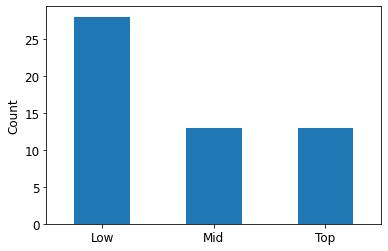

In [197]:
# Plot lables
ax = df_f_m['label'].value_counts().plot(kind='bar', fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [214]:
# Now we can filter by label
df_f_m[df_f_m['label'] == 'Top']

,location_zip,frequency_count,monetary_sum,f_score,m_score,score_total,label
0,80919,1653,489861.74,1,1,2,Top
1,80920,1641,466744.75,1,1,2,Top
2,80921,1309,347282.33,1,1,2,Top
3,80132,1268,311673.35,1,1,2,Top
4,80906,1236,449015.50,1,1,2,Top
5,80918,994,267439.92,1,1,2,Top
6,80923,822,191408.40,1,1,2,Top
7,80922,748,165392.31,1,1,2,Top
8,80907,714,201730.41,1,1,2,Top
9,80908,578,125597.60,1,1,2,Top


## 7. Save Data

In [215]:
df_f_m.to_csv("zip_f_m.csv", encoding='utf-8', index=False)